In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import re
from pathlib import Path

import pandas as pd
import xarray as xr
import pandas_indexing.accessors
from aneris.harmonize import Harmonizer
from aneris.downscaling import Downscaler
from aneris.grid import Gridder
from pandas import DataFrame
from pandas_indexing import isin, semijoin, concat

from concordia import VariableDefinitions, RegionMapping, combine_countries

In [14]:
# Potentially better gridding performance??
# from dask.distributed import Client
# client = Client()

# Read model and historic data including overrides


In [15]:
base_path = Path(
    "/Users/coroa/Library/CloudStorage/OneDrive-SharedLibraries-IIASA/RESCUE - WP 1/data"
)
data_path = Path("../data")
base_year = 2020  # in which year scenario data should be harmonized to historical data
country_combinations = {
    "sdn_ssd": ["ssd", "sdn"],
    "isr_pse": ["isr", "pse"],
    "srb_ksv": ["srb", "srb (kosovo)"],
}

## Variable definition files

The variable definition file is a CSV or yaml file that needs to contain the `variable`-name, its `sector`, `gas` components and whether it is expected `global` (or regional instead).

Here we generate one based on the cmip6 historical data we have that could be used as a basis but we would want to finetune this by hand.


In [16]:
variabledefs = VariableDefinitions.from_csv(data_path / "variabledefs-rescue.csv")
variabledefs.data.head()

,,,unit,global
variable,gas,sector,,
CEDS+|9+ Sectors|Emissions|BC|Agricultural Waste Burning,BC,Agricultural Waste Burning,Mt BC/yr,False
CEDS+|9+ Sectors|Emissions|BC|Agriculture,BC,Agriculture,Mt BC/yr,False
CEDS+|9+ Sectors|Emissions|BC|Aircraft,BC,Aircraft,Mt BC/yr,True
CEDS+|9+ Sectors|Emissions|BC|Energy Sector,BC,Energy Sector,Mt BC/yr,False
CEDS+|9+ Sectors|Emissions|BC|Forest Burning,BC,Forest Burning,Mt BC/yr,False


## RegionMapping helps reading in a region definition file


In [17]:
regionmapping = RegionMapping.from_regiondef(
    base_path / "iam_files/rescue/regionmappingH12.csv",
    country_column="CountryCode",
    region_column="RegionCode",
    sep=";",
)
regionmapping.data = combine_countries(
    regionmapping.data, **country_combinations, agg_func="first"
)

In [18]:
regionmapping.data.unique()

array(['LAM', 'OAS', 'SSA', 'EUR', 'NEU', 'MEA', 'REF', 'CAZ', 'CHA',
       'IND', 'JPN', 'USA'], dtype=object)

## Model and historic data read in

Can be read in and prepared using `read_iamc` or the `variabledefs`


In [21]:
hist = (
    pd.read_csv(
        base_path / "historical/rescue/ceds_2017_extended.csv", index_col=list(range(5))
    )
    .rename_axis(index={"Region": "Country"})
    .rename(index={"NMVOC": "VOC", "SO2": "Sulfur"}, level="gas")
    .pipe(variabledefs.load_data, levels=["country", "gas", "sector", "unit"])
    .pipe(combine_countries, **country_combinations)
)
hist.head()

ValueError: Variables missing from data:
  CEDS+|9+ Sectors|Emissions|BC|Agricultural Waste Burning,
  CEDS+|9+ Sectors|Emissions|BC|Forest Burning,
  CEDS+|9+ Sectors|Emissions|BC|Grassland Burning,
  CEDS+|9+ Sectors|Emissions|CH4|Agricultural Waste Burning,
  CEDS+|9+ Sectors|Emissions|CH4|Forest Burning,
  CEDS+|9+ Sectors|Emissions|CH4|Grassland Burning,
  CEDS+|9+ Sectors|Emissions|CO|Agricultural Waste Burning,
  CEDS+|9+ Sectors|Emissions|CO|Forest Burning,
  CEDS+|9+ Sectors|Emissions|CO|Grassland Burning,
  CEDS+|9+ Sectors|Emissions|CO2|Aggregate - Agriculture and LUC,
  CEDS+|9+ Sectors|Emissions|CO2|CDR Afforestation,
  CEDS+|9+ Sectors|Emissions|CO2|CDR BECCS,
  CEDS+|9+ Sectors|Emissions|CO2|CDR DACCS,
  CEDS+|9+ Sectors|Emissions|CO2|CDR EW,
  CEDS+|9+ Sectors|Emissions|CO2|CDR Industry,
  CEDS+|9+ Sectors|Emissions|CO2|CDR OAE,
  CEDS+|9+ Sectors|Emissions|NH3|Agricultural Waste Burning,
  CEDS+|9+ Sectors|Emissions|NH3|Forest Burning,
  CEDS+|9+ Sectors|Emissions|NH3|Grassland Burning,
  CEDS+|9+ Sectors|Emissions|NOx|Agricultural Waste Burning,
  CEDS+|9+ Sectors|Emissions|NOx|Forest Burning,
  CEDS+|9+ Sectors|Emissions|NOx|Grassland Burning,
  CEDS+|9+ Sectors|Emissions|OC|Agricultural Waste Burning,
  CEDS+|9+ Sectors|Emissions|OC|Forest Burning,
  CEDS+|9+ Sectors|Emissions|OC|Grassland Burning,
  CEDS+|9+ Sectors|Emissions|Sulfur|Agricultural Waste Burning,
  CEDS+|9+ Sectors|Emissions|Sulfur|Forest Burning,
  CEDS+|9+ Sectors|Emissions|Sulfur|Grassland Burning,
  CEDS+|9+ Sectors|Emissions|VOC|Agricultural Waste Burning,
  CEDS+|9+ Sectors|Emissions|VOC|Forest Burning,
  CEDS+|9+ Sectors|Emissions|VOC|Grassland Burning

In [22]:
hist = (
    pd.read_csv(
        base_path / "historical/rescue/ceds_2017_extended.csv", index_col=list(range(5))
    )
    .rename_axis(index={"Region": "Country"})
    .rename(index={"NMVOC": "VOC", "SO2": "Sulfur"}, level="gas")
    .rename(index={"Mt NMVOC/yr": "Mt VOC/yr"}, level="unit")
    .pipe(
        variabledefs.load_data,
        levels=["country", "gas", "sector", "unit"],
        ignore_missing=True,
    )
    .pipe(combine_countries, **country_combinations)
)
hist.head()

year                                             1751      1752      1753   
country gas sector                 unit                                     
World   BC  Agriculture            Mt BC/yr  0.000000  0.000000  0.000000  \
            Aircraft               Mt BC/yr  0.000000  0.000000  0.000000   
            Energy Sector          Mt BC/yr  0.000888  0.000891  0.000894   
            Industrial Sector      Mt BC/yr  0.008809  0.008831  0.008853   
            International Shipping Mt BC/yr  0.000000  0.000000  0.000000   

year                                             1754      1755      1756   
country gas sector                 unit                                     
World   BC  Agriculture            Mt BC/yr  0.000000  0.000000  0.000000  \
            Aircraft               Mt BC/yr  0.000000  0.000000  0.000000   
            Energy Sector          Mt BC/yr  0.000897  0.000900  0.000902   
            Industrial Sector      Mt BC/yr  0.008875  0.008898  0.008936   
            International Shipping Mt BC/yr  0.000000  0.000000  0.000000   

year                                             1757      1758      1759   
country gas sector                 unit                                     
World   BC  Agriculture            Mt BC/yr  0.000000  0.000000  0.000000  \
            Aircraft               Mt BC/yr  0.000000  0.000000  0.000000   
            Energy Sector          Mt BC/yr  0.000905  0.000908  0.000911   
            Industrial Sector      Mt BC/yr  0.008958  0.008981  0.009003   
            International Shipping Mt BC/yr  0.000000  0.000000  0.000000   

year                                             1760  ...      2007   
country gas sector                 unit                ...             
World   BC  Agriculture            Mt BC/yr  0.000000  ...  0.000000  \
            Aircraft               Mt BC/yr  0.000000  ...  0.010087   
            Energy Sector          Mt BC/yr  0.000914  ...  1.059195   
            Industrial Sector      Mt BC/yr  0.009025  ...  0.759764   
            International Shipping Mt BC/yr  0.000000  ...  0.202826   

year                                             2008      2009      2010   
country gas sector                 unit                                     
World   BC  Agriculture            Mt BC/yr  0.000000  0.000000  0.000000  \
            Aircraft               Mt BC/yr  0.009983  0.009447  0.009898   
            Energy Sector          Mt BC/yr  1.014806  1.057247  1.099077   
            Industrial Sector      Mt BC/yr  0.804503  0.843624  0.866261   
            International Shipping Mt BC/yr  0.214568  0.180402  0.165880   

year                                             2011      2012      2013   
country gas sector                 unit                                     
World   BC  Agriculture            Mt BC/yr  0.000000  0.000000  0.000000  \
            Aircraft               Mt BC/yr  0.010158  0.010287  0.010415   
            Energy Sector          Mt BC/yr  1.180117  1.193312  1.219606   
            Industrial Sector      Mt BC/yr  0.827187  0.825858  0.836870   
            International Shipping Mt BC/yr  0.188532  0.165017  0.164977   

year                                             2014      2015      2020  
country gas sector                 unit                                    
World   BC  Agriculture            Mt BC/yr  0.000000  0.000000  0.000000  
            Aircraft               Mt BC/yr  0.010468  0.010672  0.012911  
            Energy Sector          Mt BC/yr  1.191399  1.190588  1.242600  
            Industrial Sector      Mt BC/yr  0.836264  0.827216  0.732658  
            International Shipping Mt BC/yr  0.166383  0.170542  0.177687  

[5 rows x 266 columns]

In [23]:
model = (
    pd.read_csv(
        base_path / "iam_files/rescue/RESCUE-REMIND_MAgPIE-EoCBudg500-OAE_on-TEST.csv",
        index_col=list(range(5)),
        sep=";",
    )
    .drop(["Unnamed: 21"], axis=1)
    .rename(
        index={"Mt CO2-equiv/yr": "Mt CO2-eq/yr", "Mt NOX/yr": "Mt NOx/yr"},
        level="Unit",
    )
    .pipe(
        variabledefs.load_data,
        levels=["model", "scenario", "region", "gas", "sector", "unit"],
    )
)
model.head()

year                                                                                       2005   
model         scenario                 region gas sector                     unit                 
REMIND-MAgPIE RESCUE-EoCBudg500-OAE_on CAZ    BC  Agricultural Waste Burning Mt BC/yr  0.028446  \
                                       CHA    BC  Agricultural Waste Burning Mt BC/yr  0.069621   
                                       EUR    BC  Agricultural Waste Burning Mt BC/yr  0.033175   
                                       IND    BC  Agricultural Waste Burning Mt BC/yr  0.047972   
                                       JPN    BC  Agricultural Waste Burning Mt BC/yr  0.000496   

year                                                                                       2010   
model         scenario                 region gas sector                     unit                 
REMIND-MAgPIE RESCUE-EoCBudg500-OAE_on CAZ    BC  Agricultural Waste Burning Mt BC/yr  0.031792  \
                                       CHA    BC  Agricultural Waste Burning Mt BC/yr  0.077738   
                                       EUR    BC  Agricultural Waste Burning Mt BC/yr  0.033775   
                                       IND    BC  Agricultural Waste Burning Mt BC/yr  0.050027   
                                       JPN    BC  Agricultural Waste Burning Mt BC/yr  0.000510   

year                                                                                       2015   
model         scenario                 region gas sector                     unit                 
REMIND-MAgPIE RESCUE-EoCBudg500-OAE_on CAZ    BC  Agricultural Waste Burning Mt BC/yr  0.032587  \
                                       CHA    BC  Agricultural Waste Burning Mt BC/yr  0.083447   
                                       EUR    BC  Agricultural Waste Burning Mt BC/yr  0.034290   
                                       IND    BC  Agricultural Waste Burning Mt BC/yr  0.053257   
                                       JPN    BC  Agricultural Waste Burning Mt BC/yr  0.000517   

year                                                                                       2020   
model         scenario                 region gas sector                     unit                 
REMIND-MAgPIE RESCUE-EoCBudg500-OAE_on CAZ    BC  Agricultural Waste Burning Mt BC/yr  0.034162  \
                                       CHA    BC  Agricultural Waste Burning Mt BC/yr  0.081302   
                                       EUR    BC  Agricultural Waste Burning Mt BC/yr  0.036861   
                                       IND    BC  Agricultural Waste Burning Mt BC/yr  0.052141   
                                       JPN    BC  Agricultural Waste Burning Mt BC/yr  0.000524   

year                                                                                       2025   
model         scenario                 region gas sector                     unit                 
REMIND-MAgPIE RESCUE-EoCBudg500-OAE_on CAZ    BC  Agricultural Waste Burning Mt BC/yr  0.035251  \
                                       CHA    BC  Agricultural Waste Burning Mt BC/yr  0.083875   
                                       EUR    BC  Agricultural Waste Burning Mt BC/yr  0.037033   
                                       IND    BC  Agricultural Waste Burning Mt BC/yr  0.054137   
                                       JPN    BC  Agricultural Waste Burning Mt BC/yr  0.000559   

year                                                                                       2030   
model         scenario                 region gas sector                     unit                 
REMIND-MAgPIE RESCUE-EoCBudg500-OAE_on CAZ    BC  Agricultural Waste Burning Mt BC/yr  0.036394  \
                                       CHA    BC  Agricultural Waste Burning Mt BC/yr  0.086449   
                                       EUR    BC  Agricultural Waste Burning Mt BC/yr  0.037204   
                                   

In [24]:
harm_overrides = (
    pd.read_excel(
        base_path / "iam_files/cmip6/REMIND-MAGPIE_SSP5-34-OS/ssp5-34-os.xlsx",
        sheet_name="harmonization",
        index_col=list(range(4)),
        usecols=list(range(5)),
    )
    .rename_axis(index=str.lower)
    .rename(columns=str.lower)
    .pipe(
        variabledefs.load_data,
        ignore_missing=True,
        levels=["region", "gas", "sector"],
        timeseries=False,
    )
    .method
)

harm_overrides.head()

Series([], Name: method, dtype: object)

In [25]:
hist_available = hist.pix.unique(["gas", "sector"])

In [26]:
model.pix.unique(["gas", "sector"]).difference(hist_available)

MultiIndex([(    'BC',      'Agricultural Waste Burning'),
            (    'BC',                  'Forest Burning'),
            (    'BC',               'Grassland Burning'),
            (   'CH4',      'Agricultural Waste Burning'),
            (   'CH4',                  'Forest Burning'),
            (   'CH4',               'Grassland Burning'),
            (    'CO',      'Agricultural Waste Burning'),
            (    'CO',                  'Forest Burning'),
            (    'CO',               'Grassland Burning'),
            (   'CO2', 'Aggregate - Agriculture and LUC'),
            (   'CO2',               'CDR Afforestation'),
            (   'CO2',                       'CDR BECCS'),
            (   'CO2',                       'CDR DACCS'),
            (   'CO2',                          'CDR EW'),
            (   'CO2',                    'CDR Industry'),
            (   'CO2',                         'CDR OAE'),
            (   'NH3',      'Agricultural Waste Burning'

In [28]:
model = model.pix.semijoin(hist_available, how="right")

In [29]:
variabledefs.data = variabledefs.data.pix.semijoin(hist_available, how="right")

# Harmonization

## Preparation of input data


In [30]:
hist_agg = pd.concat(
    [
        hist.pix.semijoin(variabledefs.index_regional, how="inner").pipe(
            regionmapping.aggregate
        ),
        hist.pix.semijoin(variabledefs.index_global, how="inner")
        .loc[isin(country="World")]
        .rename_axis(index={"country": "region"}),
    ]
)

In [31]:
model_agg = pd.concat(
    [
        model.pix.semijoin(variabledefs.index_regional, how="inner").loc[
            isin(region=regionmapping.data.unique())
        ],
        model.pix.semijoin(variabledefs.index_global, how="inner").loc[
            isin(region="World")
        ],
    ]
)

## Harmonize all model, scenarios combinations


In [33]:
harmonized = []
for m, s in model.index.pix.project(["model", "scenario"]).unique():
    scen = model_agg.loc[isin(model=m, scenario=s)].droplevel(["model", "scenario"])
    h = Harmonizer(
        scen, hist_agg.pix.semijoin(scen.index, how="right"), harm_idx=scen.index.names
    )
    result = h.harmonize(
        year=base_year, overrides=None if harm_overrides.empty else harm_overrides
    )
    harmonized.append(result.pix.assign(model=m, scenario=s))
harmonized = pd.concat(harmonized)

# TODO harmonization casts columns to str!!
harmonized = harmonized.rename(columns=int)
harmonized.loc[isin(sector="Energy Sector")].head()

/Users/coroa/repos/aneris/src/aneris/methods.py:389: RuntimeWarning: invalid value encountered in scalar divide
  return np.abs(np.std(x) / np.mean(x))
INFO:root:Harmonizing with hist_zero
INFO:root:Harmonizing with reduce_offset_2150_cov
INFO:root:Harmonizing with constant_ratio
INFO:root:Harmonizing with reduce_ratio_2080
INFO:root:Harmonizing with model_zero
INFO:root:Harmonizing with constant_offset


year                                                                          2020   
gas sector        region unit     model         scenario                             
BC  Energy Sector CAZ    Mt BC/yr REMIND-MAgPIE RESCUE-EoCBudg500-OAE_on  0.002982  \
                  CHA    Mt BC/yr REMIND-MAgPIE RESCUE-EoCBudg500-OAE_on  0.836904   
                  EUR    Mt BC/yr REMIND-MAgPIE RESCUE-EoCBudg500-OAE_on  0.037837   
                  IND    Mt BC/yr REMIND-MAgPIE RESCUE-EoCBudg500-OAE_on  0.056000   
                  JPN    Mt BC/yr REMIND-MAgPIE RESCUE-EoCBudg500-OAE_on  0.014897   

year                                                                          2025   
gas sector        region unit     model         scenario                             
BC  Energy Sector CAZ    Mt BC/yr REMIND-MAgPIE RESCUE-EoCBudg500-OAE_on  0.002790  \
                  CHA    Mt BC/yr REMIND-MAgPIE RESCUE-EoCBudg500-OAE_on  0.632860   
                  EUR    Mt BC/yr REMIND-MAgPIE RESCUE-EoCBudg500-OAE_on  0.035645   
                  IND    Mt BC/yr REMIND-MAgPIE RESCUE-EoCBudg500-OAE_on  0.060204   
                  JPN    Mt BC/yr REMIND-MAgPIE RESCUE-EoCBudg500-OAE_on  0.013412   

year                                                                          2030   
gas sector        region unit     model         scenario                             
BC  Energy Sector CAZ    Mt BC/yr REMIND-MAgPIE RESCUE-EoCBudg500-OAE_on  0.002697  \
                  CHA    Mt BC/yr REMIND-MAgPIE RESCUE-EoCBudg500-OAE_on  0.420808   
                  EUR    Mt BC/yr REMIND-MAgPIE RESCUE-EoCBudg500-OAE_on  0.033820   
                  IND    Mt BC/yr REMIND-MAgPIE RESCUE-EoCBudg500-OAE_on  0.062846   
                  JPN    Mt BC/yr REMIND-MAgPIE RESCUE-EoCBudg500-OAE_on  0.009643   

year                                                                          2035   
gas sector        region unit     model         scenario                             
BC  Energy Sector CAZ    Mt BC/yr REMIND-MAgPIE RESCUE-EoCBudg500-OAE_on  0.002556  \
                  CHA    Mt BC/yr REMIND-MAgPIE RESCUE-EoCBudg500-OAE_on  0.392615   
                  EUR    Mt BC/yr REMIND-MAgPIE RESCUE-EoCBudg500-OAE_on  0.031962   
                  IND    Mt BC/yr REMIND-MAgPIE RESCUE-EoCBudg500-OAE_on  0.055912   
                  JPN    Mt BC/yr REMIND-MAgPIE RESCUE-EoCBudg500-OAE_on  0.008175   

year                                                                          2040   
gas sector        region unit     model         scenario                             
BC  Energy Sector CAZ    Mt BC/yr REMIND-MAgPIE RESCUE-EoCBudg500-OAE_on  0.002338  \
                  CHA    Mt BC/yr REMIND-MAgPIE RESCUE-EoCBudg500-OAE_on  0.366468   
                  EUR    Mt BC/yr REMIND-MAgPIE RESCUE-EoCBudg500-OAE_on  0.030195   
                  IND    Mt BC/yr REMIND-MAgPIE RESCUE-EoCBudg500-OAE_on  0.051367   
                  JPN    Mt BC/yr REMIND-MAgPIE RESCUE-EoCBudg500-OAE_on  0.008157   

year                                                                          2045   
gas sector        region unit     model         scenario                             
BC  Energy Sector CAZ    Mt BC/yr REMIND-MAgPIE RESCUE-EoCBudg500-OAE_on  0.002133  \
                  CHA    Mt BC/yr REMIND-MAgPIE RESCUE-EoCBudg500-OAE_on  0.347445   
                  EUR    Mt BC/yr REMIND-MAgPIE RESCUE-EoCBudg500-OAE_on  0.028598   
                  IND    Mt BC/yr REMIND-MAgPIE RESCUE-EoCBudg500-OAE_on  0.047815   
                  JPN    Mt BC/yr REMIND-MAgPIE RESCUE-EoCBudg500-OAE_on  0.008143   

year                                                                          2050   
gas sector        region unit     model         scenario                             
BC  Energy Sector CAZ    Mt BC/yr REMIND-MAgPIE RESCUE-EoCBudg500-OAE_on  0.001953  \
                  CHA    Mt BC/yr REMIND-MAgPIE RESCUE-EoCBudg500-OAE_on  0.333307   
                  EUR    Mt BC/yr REMI

In [35]:
methods = h.methods(year=base_year)
methods.head()

/Users/coroa/repos/aneris/src/aneris/methods.py:389: RuntimeWarning: invalid value encountered in scalar divide
  return np.abs(np.std(x) / np.mean(x))


gas  sector       region  unit    
BC   Agriculture  CAZ     Mt BC/yr    hist_zero
                  CHA     Mt BC/yr    hist_zero
                  EUR     Mt BC/yr    hist_zero
                  IND     Mt BC/yr    hist_zero
                  JPN     Mt BC/yr    hist_zero
Name: method, dtype: object

In [55]:
version = "2023-07-11"
data = concat(
    [
        model_agg.pix.format(
            variable="Emissions|{gas}|{sector}|Unharmonized", drop=True
        ),
        harmonized.pix.assign(
            method=methods.pix.semijoin(harmonized.index, how="right")
        ).pix.format(
            variable="Emissions|{gas}|{sector}|Harmonized|{method}", drop=True
        ),
        hist_agg.loc[:, 1990:].pix.format(
            model="CEDS",
            scenario="Synthetic",
            variable="Emissions|{gas}|{sector}",
            drop=True,
        ),
    ],
    order=["model", "scenario", "region", "variable", "unit"],
).sort_index(axis=1)
data.to_csv(f"harmonization-{version}.csv")

In [56]:
data.head()

year                                                                                          1990   
model         scenario                 region variable                              unit             
REMIND-MAgPIE RESCUE-EoCBudg500-OAE_on CAZ    Emissions|BC|Agriculture|Unharmonized Mt BC/yr   NaN  \
                                       CHA    Emissions|BC|Agriculture|Unharmonized Mt BC/yr   NaN   
                                       EUR    Emissions|BC|Agriculture|Unharmonized Mt BC/yr   NaN   
                                       IND    Emissions|BC|Agriculture|Unharmonized Mt BC/yr   NaN   
                                       JPN    Emissions|BC|Agriculture|Unharmonized Mt BC/yr   NaN   

year                                                                                          1991   
model         scenario                 region variable                              unit             
REMIND-MAgPIE RESCUE-EoCBudg500-OAE_on CAZ    Emissions|BC|Agriculture|Unharmonized Mt BC/yr   NaN  \
                                       CHA    Emissions|BC|Agriculture|Unharmonized Mt BC/yr   NaN   
                                       EUR    Emissions|BC|Agriculture|Unharmonized Mt BC/yr   NaN   
                                       IND    Emissions|BC|Agriculture|Unharmonized Mt BC/yr   NaN   
                                       JPN    Emissions|BC|Agriculture|Unharmonized Mt BC/yr   NaN   

year                                                                                          1992   
model         scenario                 region variable                              unit             
REMIND-MAgPIE RESCUE-EoCBudg500-OAE_on CAZ    Emissions|BC|Agriculture|Unharmonized Mt BC/yr   NaN  \
                                       CHA    Emissions|BC|Agriculture|Unharmonized Mt BC/yr   NaN   
                                       EUR    Emissions|BC|Agriculture|Unharmonized Mt BC/yr   NaN   
                                       IND    Emissions|BC|Agriculture|Unharmonized Mt BC/yr   NaN   
                                       JPN    Emissions|BC|Agriculture|Unharmonized Mt BC/yr   NaN   

year                                                                                          1993   
model         scenario                 region variable                              unit             
REMIND-MAgPIE RESCUE-EoCBudg500-OAE_on CAZ    Emissions|BC|Agriculture|Unharmonized Mt BC/yr   NaN  \
                                       CHA    Emissions|BC|Agriculture|Unharmonized Mt BC/yr   NaN   
                                       EUR    Emissions|BC|Agriculture|Unharmonized Mt BC/yr   NaN   
                                       IND    Emissions|BC|Agriculture|Unharmonized Mt BC/yr   NaN   
                                       JPN    Emissions|BC|Agriculture|Unharmonized Mt BC/yr   NaN   

year                                                                                          1994   
model         scenario                 region variable                              unit             
REMIND-MAgPIE RESCUE-EoCBudg500-OAE_on CAZ    Emissions|BC|Agriculture|Unharmonized Mt BC/yr   NaN  \
                                       CHA    Emissions|BC|Agriculture|Unharmonized Mt BC/yr   NaN   
                                       EUR    Emissions|BC|Agriculture|Unharmonized Mt BC/yr   NaN   
                                       IND    Emissions|BC|Agriculture|Unharmonized Mt BC/yr   NaN   
                                       JPN    Emissions|BC|Agriculture|Unharmonized Mt BC/yr   NaN   

year                                                                                          1995   
model         scenario                 region variable                              unit             
REMIND-MAgPIE RESCUE-EoCBudg500-OAE_on CAZ    Emissions|BC|Agriculture|Unharmonized Mt BC/yr   NaN  \
                                       CHA    Emissions|BC|Agriculture|Unharmonized Mt BC/yr   NaN   
                 

In [46]:
version = "2023-07-11"

In [47]:
data = concat(
    [
        model_agg.pix.assign(method="-"),
        harmonized.pix.assign(
            method=methods.pix.semijoin(harmonized.index, how="right")
        ),
        hist_agg.pix.assign(model="CEDS", scenario="Synthetic", method="-"),
    ]
)
data.to_csv(f"harmonization-{version}.csv")

In [37]:
from pandas_indexing import set_openscm_registry_as_default

In [38]:
ur = set_openscm_registry_as_default()

In [44]:
for gas in model.pix.unique("gas"):
    print(
        gas,
        (harmonized - model).loc[isin(gas=gas), 2020:2050].sum(axis=0).sum()
        / model.loc[isin(gas=gas), 2020:2050].sum().sum()
        * 100,
    )

BC 1.7262468764709265
CH4 3.7503156542370837
CO 13.571151346972018
CO2 0.9527625881665515
NH3 1964.6606696206145
NOx 10.71665610303077
OC 18.38376577470959


In [45]:
for gas in model.pix.unique("gas"):
    print(
        gas,
        (harmonized - model).loc[isin(gas=gas), 2020:2100].sum(axis=0).sum()
        / model.loc[isin(gas=gas), 2020:2100].sum().sum()
        * 100,
    )

BC 1.6724548261218164
CH4 3.9813525298310766
CO 16.718089883696123
CO2 1.0245153801937963
NH3 2398.391143724513
NOx 13.014466212082304
OC 19.36087021191136


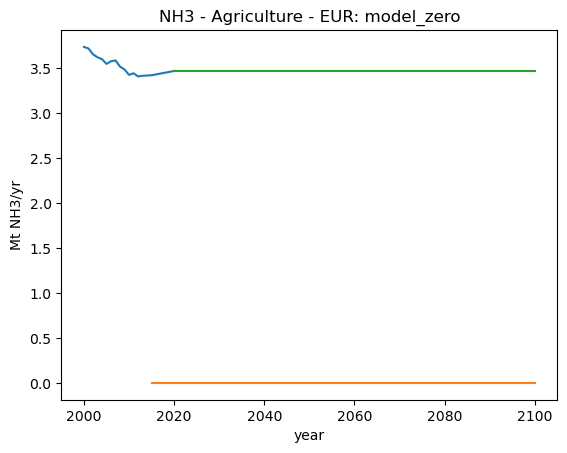

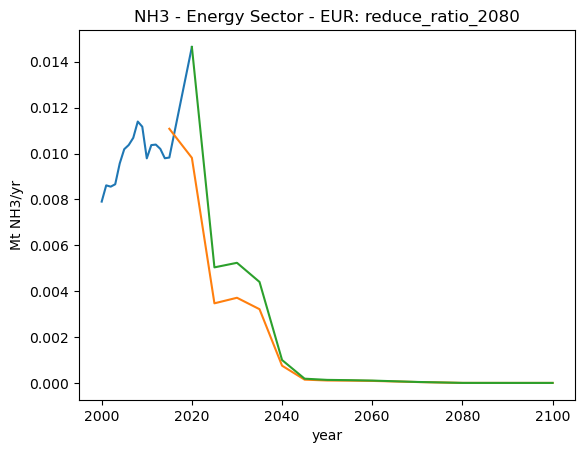

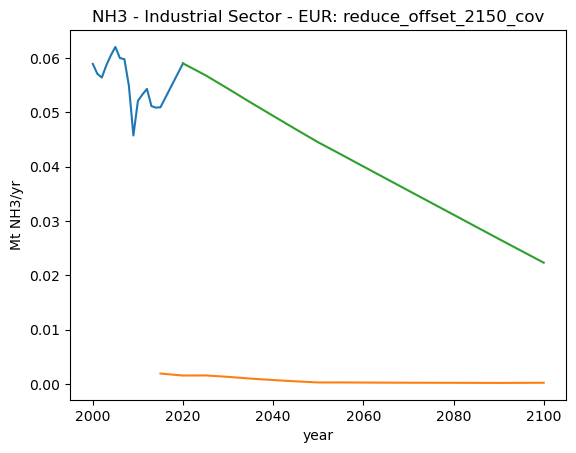

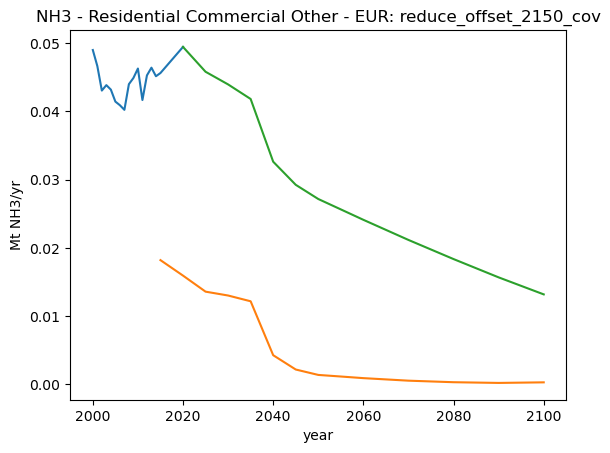

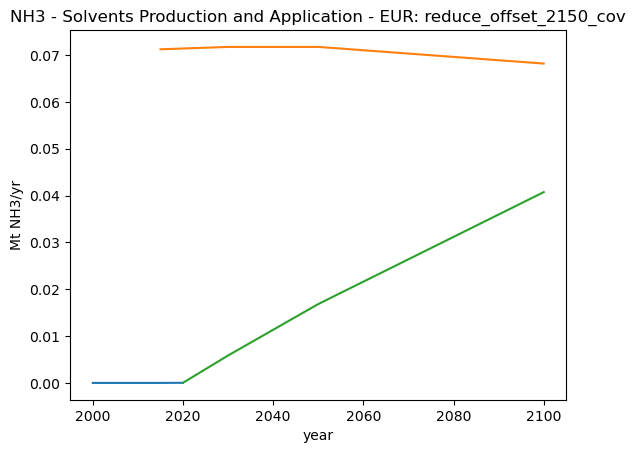

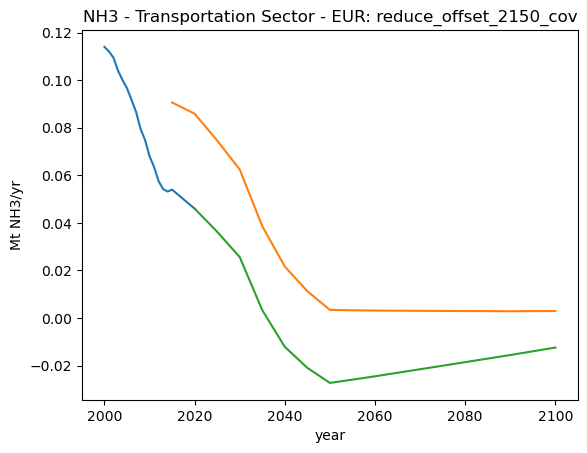

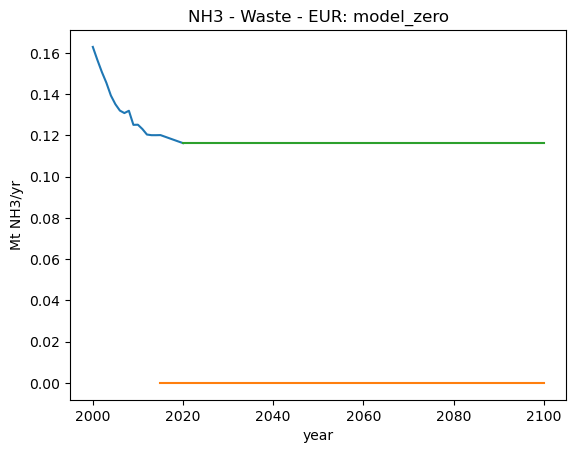

In [46]:
for region, sector, gas in harmonized.loc[
    isin(gas=["NH3"], region=["EUR", "AFR"])
].pix.unique(["region", "sector", "gas"]):
    sel = isin(region=region, sector=sector, gas=gas)
    data = concat(
        [
            hist_agg.loc[sel].pix.assign(model="CEDS", scenario="Historic"),
            model.loc[sel],
            harmonized.loc[sel],
        ]
    ).loc[:, 2000:]
    data.T.plot(
        ylabel=data.pix.unique("unit").item(),
        title=" - ".join(data.pix.unique(["gas", "sector", "region"])[0])
        + ": "
        + methods.loc[sel].item(),
        legend=False,
    )

# Downscaling


## Prepare GDP proxy

Read in different GDP scenarios for SSP1 to SSP5 from SSP DB.


In [67]:
gdp = (
    pd.read_csv(
        base_path / "historical" / "SspDb_country_data_2013-06-12.csv",
        index_col=list(range(5)),
    )
    .rename_axis(index=str.lower)
    .loc[
        isin(
            model="OECD Env-Growth",
            scenario=[f"SSP{n+1}_v9_130325" for n in range(5)],
            variable="GDP|PPP",
        )
    ]
    .dropna(how="all", axis=1)
    .rename_axis(index={"scenario": "ssp", "region": "country"})
    .rename(index=str.lower, level="country")
    .rename(columns=int)
    .pix.project(["ssp", "country"])
    .pipe(combine_countries, **country_combinations)
)
gdp.head()

2000     2005     2010     2015     2020     2025   
ssp            country                                                         
SSP1_v9_130325 abw        0.000    0.128    0.151    0.205    0.266    0.357  \
               afg        0.000   22.372   37.237   47.643   59.153   78.506   
               ago       34.484   55.315   98.686  127.295  171.984  203.363   
               alb       14.743   19.170   24.545   26.919   30.452   35.126   
               are      209.548  272.055  318.142  439.900  536.362  652.339   

                           2030     2035      2040      2045  ...      2055   
ssp            country                                        ...             
SSP1_v9_130325 abw        0.492    0.679     0.926     1.237  ...     2.067  \
               afg      109.567  157.250   227.005   324.841  ...   627.328   
               ago      232.320  261.469   304.102   369.997  ...   591.431   
               alb       41.037   48.034    55.608    63.289  ...    76.939   
               are      787.776  927.181  1061.287  1176.838  ...  1343.919   

                            2060      2065      2070      2075      2080   
ssp            country                                                     
SSP1_v9_130325 abw         2.586     3.165     3.797     4.470     5.171  \
               afg       839.381  1094.144  1389.577  1722.005  2086.194   
               ago       750.860   942.049  1160.284  1400.116  1655.046   
               alb        83.030    88.331    92.473    95.687    98.004   
               are      1421.730  1487.358  1535.672  1560.609  1569.904   

                            2085      2090      2095      2100  
ssp            country                                          
SSP1_v9_130325 abw         5.842     6.469     7.034     7.505  
               afg      2474.187  2878.709  3293.204  3707.958  
               ago      1917.629  2181.823  2441.164  2687.836  
               alb        99.153    99.277    98.596    97.006  
               are      1565.244  1550.719  1526.111  1486.250  

[5 rows x 21 columns]

Determine likely SSP for each harmonized pathway from scenario string and create proxy data aligned with pathways


In [68]:
SSP_per_pathway = (
    harmonized.index.pix.project(["model", "scenario"])
    .unique()
    .to_frame()
    .scenario.str.extract("(SSP[1-5])")[0]
    .fillna("SSP2")
)
gdp = semijoin(
    gdp,
    SSP_per_pathway.index.pix.assign(ssp=SSP_per_pathway + "_v9_130325"),
    how="right",
).pix.project(["model", "scenario", "country"])
gdp.head()

2000     2005     2010     2015   
model         scenario       country                                       
REMIND-MAGPIE SSP5-34-OS-V27 abw        0.000    0.128    0.151    0.208  \
                             afg        0.000   22.372   37.237   47.532   
                             ago       34.484   55.315   98.686  127.389   
                             alb       14.743   19.170   24.545   26.838   
                             are      209.548  272.055  318.142  453.516   

                                         2020     2025     2030      2035   
model         scenario       country                                        
REMIND-MAGPIE SSP5-34-OS-V27 abw        0.277    0.395    0.589     0.885  \
                             afg       58.848   79.059  114.303   171.645   
                             ago      173.632  214.748  264.116   323.521   
                             alb       30.302   35.462   42.765    51.992   
                             are      567.148  720.458  921.726  1160.236   

                                          2040      2045  ...      2055   
model         scenario       country                      ...             
REMIND-MAGPIE SSP5-34-OS-V27 abw         1.291     1.823  ...     3.327  \
                             afg       257.527   380.116  ...   767.620   
                             ago       401.276   510.353  ...   869.382   
                             alb        62.170    72.826  ...    93.510   
                             are      1414.170  1658.828  ...  2073.427   

                                          2060      2065      2070      2075   
model         scenario       country                                           
REMIND-MAGPIE SSP5-34-OS-V27 abw         4.318     5.468     6.769     8.208  \
                             afg      1044.537  1383.535  1785.195  2249.365   
                             ago      1133.130  1456.094  1833.656  2260.130   
                             alb       103.790   113.536   121.975   129.225   
                             are      2269.341  2449.734  2606.055  2727.411   

                                          2080      2085      2090      2095   
model         scenario       country                                           
REMIND-MAGPIE SSP5-34-OS-V27 abw         9.770    11.351    12.921    14.432  \
                             afg      2776.635  3362.675  4004.527  4700.203   
                             ago      2727.862  3227.709  3752.107  4292.043   
                             alb       135.404   140.236   143.913   146.697   
                             are      2826.731  2907.985  2972.880  3018.047   

                                          2100  
model         scenario       country            
REMIND-MAGPIE SSP5-34-OS-V27 abw        15.810  
                             afg      5442.728  
                             ago      4834.886  
                             alb       148.263  
                             are      3029.692  

[5 rows x 21 columns]

In [71]:
downscaler = Downscaler(
    harmonized.pix.semijoin(variabledefs.index_regional, how="inner"),
    hist.pix.semijoin(variabledefs.index_regional, how="inner"),
    base_year,
    regionmapping.data,
    gdp=gdp,
)
results = downscaler.downscale()

/Users/coroa/repos/aneris/src/aneris/methods.py:389: RuntimeWarning: invalid value encountered in scalar divide
  return np.abs(np.std(x) / np.mean(x))
/Users/coroa/repos/aneris/src/aneris/downscaling/intensity_convergence.py:328: RuntimeWarning: invalid value encountered in multiply
  (


In [72]:
downscaler.methods().value_counts()

/Users/coroa/repos/aneris/src/aneris/methods.py:389: RuntimeWarning: invalid value encountered in scalar divide
  return np.abs(np.std(x) / np.mean(x))


method
ipat_2100_gdp        781
proxy_gdp            132
base_year_pattern     33
Name: count, dtype: int64

In [73]:
results

year                                                                                                  2015   
gas    sector                              region unit      model         scenario       country             
CH4    Agriculture                         AFR    Mt CH4/yr REMIND-MAGPIE SSP5-34-OS-V27 ago      0.220823  \
                                                                                         bdi      0.036465   
                                                                                         ben      0.095516   
                                                                                         bfa      0.511754   
                                                                                         bwa      0.105129   
...                                                                                                    ...   
Sulfur Agriculture                         USA    Mt SO2/yr REMIND-MAGPIE SSP5-34-OS-V27 usa      0.000000   
       Solvents Production and Application USA    Mt SO2/yr REMIND-MAGPIE SSP5-34-OS-V27 pri      0.000000   
                                                                                         usa      0.000000   
VOC    Agriculture                         USA    Mt VOC/yr REMIND-MAGPIE SSP5-34-OS-V27 pri      0.000000   
                                                                                         usa      0.000000   

year                                                                                                  2020   
gas    sector                              region unit      model         scenario       country             
CH4    Agriculture                         AFR    Mt CH4/yr REMIND-MAGPIE SSP5-34-OS-V27 ago      0.279381  \
                                                                                         bdi      0.046135   
                                                                                         ben      0.120845   
                                                                                         bfa      0.647461   
                                                                                         bwa      0.133007   
...                                                                                                    ...   
Sulfur Agriculture                         USA    Mt SO2/yr REMIND-MAGPIE SSP5-34-OS-V27 usa      0.000000   
       Solvents Production and Application USA    Mt SO2/yr REMIND-MAGPIE SSP5-34-OS-V27 pri      0.000000   
                                                                                         usa      0.000000   
VOC    Agriculture                         USA    Mt VOC/yr REMIND-MAGPIE SSP5-34-OS-V27 pri      0.000000   
                                                                                         usa      0.000000   

year                                                                                                  2030   
gas    sector                              region unit      model         scenario       country             
CH4    Agriculture                         AFR    Mt CH4/yr REMIND-MAGPIE SSP5-34-OS-V27 ago      0.515045  \
                                                                                         bdi      0.085051   
                                                                                         ben      0.222780   
                                                                                         bfa      1.193611   
                                                                                         bwa      0.245201   
...                                                                                                    ...   
Sulfur Agriculture                         USA    Mt SO2/yr REMIND-MAGPIE SSP5-34-OS-V27 usa      0.000000   
       Solvents Production and Application USA    Mt SO2/yr REMIND-MAGPIE SSP5-34-OS-V27 pri      0.000000   
                                      

# Gridding


In [27]:
idxr = xr.open_dataarray(
    base_path / "gridding_process_files" / "iso_mask.nc", chunks={"iso": 20}
).rename({"iso": "country"})

/Users/coroa/repos/pandas-indexing/src/pandas_indexing/accessors.py:174: UserWarning: registration of accessor <class 'pandas_indexing.accessors.DataFrameIdxAccessor'> under name 'idx' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  @pd.api.extensions.register_dataframe_accessor("idx")
/Users/coroa/repos/pandas-indexing/src/pandas_indexing/accessors.py:179: UserWarning: registration of accessor <class 'pandas_indexing.accessors.SeriesIdxAccessor'> under name 'idx' for type <class 'pandas.core.series.Series'> is overriding a preexisting attribute with the same name.
  @pd.api.extensions.register_series_accessor("idx")
/Users/coroa/repos/pandas-indexing/src/pandas_indexing/accessors.py:184: UserWarning: registration of accessor <class 'pandas_indexing.accessors.IndexIdxAccessor'> under name 'idx' for type <class 'pandas.core.indexes.base.Index'> is overriding a preexisting attribute with the same name.
  @pd.api.extensions.regist

In [34]:
proxy_dir = base_path / "gridding_process_files" / "proxy_rasters"
proxy_cfg = pd.concat(
    [
        # DataFrame(
        #     {
        #         "path": proxy_dir.glob("aircraft_*.nc"),
        #         "name": "em-AIR-anthro",
        #         "separate_shares": False,
        #     }
        # ),
        DataFrame(
            {
                "path": proxy_dir.glob("anthro_*.nc"),
                "name": "em-anthro",
                "separate_shares": False,
            }
        ),
        DataFrame(
            {
                "path": proxy_dir.glob("openburning_*.nc"),
                "name": "em-openburning",
                "separate_shares": True,
            }
        ),
        # DataFrame({"path": proxy_dir.glob("shipping_*.nc"), "name": ..., "template": ..., "separate_shares": False})
    ]
).assign(
    name=lambda df: df.path.map(lambda p: p.stem.split("_")[1]) + "-" + df.name,
    template="{name}_emissions_{model}-{scenario}_201501-210012",
)
proxy_cfg.head()

,path,name,separate_shares,template
0,/Users/coroa/Library/CloudStorage/OneDrive-Sha...,OC-em-anthro,False,{name}_emissions_{model}-{scenario}_201501-210012
1,/Users/coroa/Library/CloudStorage/OneDrive-Sha...,CO-em-anthro,False,{name}_emissions_{model}-{scenario}_201501-210012
2,/Users/coroa/Library/CloudStorage/OneDrive-Sha...,NH3-em-anthro,False,{name}_emissions_{model}-{scenario}_201501-210012
3,/Users/coroa/Library/CloudStorage/OneDrive-Sha...,NOx-em-anthro,False,{name}_emissions_{model}-{scenario}_201501-210012
4,/Users/coroa/Library/CloudStorage/OneDrive-Sha...,CO2-em-anthro,False,{name}_emissions_{model}-{scenario}_201501-210012


In [21]:
sector_mapping = {
    "AIR": "Aircraft",
    "SHP": "International Shipping",
    "AWB": "Agricultural Waste Burning",
    "AGR": "Agriculture",
    "ENE": "Energy Sector",
    "FRTB": "Forest Burning",
    "GRSB": "Grassland Burning",
    "IND": "Industrial Sector",
    "PEAT": "Peat Burning",
    "RCO": "Residential Commercial Other",
    "SLV": "Solvents Production and Application",
    "TRA": "Transportation Sector",
    "WST": "Waste",
}

In [42]:
kg_per_mt = 1e9
s_per_yr = 365 * 24 * 60 * 60
results = (
    results.rename(index=lambda s: re.sub("Mt (.*)/yr", r"kg \1/s", s), level="unit")
    * kg_per_mt
    / s_per_yr
)

In [43]:
results = results.droplevel("region")
results.head()

year                                                                2015   
gas sector      unit     model         scenario       country              
CH4 Agriculture kg CH4/s REMIND-MAGPIE SSP5-34-OS-V27 ago       7.002247  \
                                                      bdi       1.156298   
                                                      ben       3.028788   
                                                      bfa      16.227619   
                                                      bwa       3.333608   

year                                                                2020   
gas sector      unit     model         scenario       country              
CH4 Agriculture kg CH4/s REMIND-MAGPIE SSP5-34-OS-V27 ago       8.859105  \
                                                      bdi       1.462925   
                                                      ben       3.831963   
                                                      bfa      20.530863   
                                                      bwa       4.217615   

year                                                                2030   
gas sector      unit     model         scenario       country              
CH4 Agriculture kg CH4/s REMIND-MAGPIE SSP5-34-OS-V27 ago      16.331986  \
                                                      bdi       2.696940   
                                                      ben       7.064321   
                                                      bfa      37.849168   
                                                      bwa       7.775281   

year                                                                2040   
gas sector      unit     model         scenario       country              
CH4 Agriculture kg CH4/s REMIND-MAGPIE SSP5-34-OS-V27 ago      27.781679  \
                                                      bdi       4.587656   
                                                      ben      12.016831   
                                                      bfa      64.383687   
                                                      bwa      13.226216   

year                                                                2050   
gas sector      unit     model         scenario       country              
CH4 Agriculture kg CH4/s REMIND-MAGPIE SSP5-34-OS-V27 ago      24.593980  \
                                                      bdi       4.061263   
                                                      ben      10.638007   
                                                      bfa      56.996234   
                                                      bwa      11.708626   

year                                                                2060   
gas sector      unit     model         scenario       country              
CH4 Agriculture kg CH4/s REMIND-MAGPIE SSP5-34-OS-V27 ago      12.604726  \
                                                      bdi       2.081449   
                                                      ben       5.452113   
                                                      bfa      29.211290   
                                                      bwa       6.000819   

year                                                                2070   
gas sector      unit     model         scenario       country              
CH4 Agriculture kg CH4/s REMIND-MAGPIE SSP5-34-OS-V27 ago       5.649102  \
                                                      bdi       0.932850   
                                                      ben       2.443492   
                                                      bfa      13.091722   
                                                      bwa       2.689407   

year                                                                2080   
gas sector      unit     model         scenario       country              
CH4 Agriculture kg CH4/s REMIND-MAGPIE SSP5-34-OS-V27 ago       4.963229  \
                                         

In [45]:
gridder = Gridder(
    results,
    idxr,
    proxy_cfg,
    index_mappings=dict(sector=sector_mapping),
    output_dir="../results",
)

In [50]:
gridder.grid(skip_check=True)

INFO:root:Collecting tasks for proxy OC-em-anthro
/Users/coroa/.local/conda/envs/concordia/lib/python3.11/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(
INFO:root:Adding tasks for {'unit': 'kg OC/s', 'model': 'REMIND-MAGPIE', 'scenario': 'SSP5-34-OS-V27'}
INFO:root:Writing to ../results/OC-em-anthro_emissions_REMIND-MAGPIE-SSP5-34-OS-V27_201501-210012.nc
INFO:root:Adding tasks for {'unit': 'kg OC/s', 'model': 'IMAGE', 'scenario': 'SSP2'}
INFO:root:Writing to ../results/OC-em-anthro_emissions_IMAGE-SSP2_201501-210012.nc


[                                        ] | 0% Completed | 8.98 s ms

/Users/coroa/.local/conda/envs/concordia/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed | 12m 58s


INFO:root:Collecting tasks for proxy CO-em-anthro
/Users/coroa/.local/conda/envs/concordia/lib/python3.11/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(
INFO:root:Adding tasks for {'unit': 'kg CO/s', 'model': 'REMIND-MAGPIE', 'scenario': 'SSP5-34-OS-V27'}
INFO:root:Writing to ../results/CO-em-anthro_emissions_REMIND-MAGPIE-SSP5-34-OS-V27_201501-210012.nc
INFO:root:Adding tasks for {'unit': 'kg CO/s', 'model': 'IMAGE', 'scenario': 'SSP2'}
INFO:root:Writing to ../results/CO-em-anthro_emissions_IMAGE-SSP2_201501-210012.nc


[                                        ] | 0% Completed | 7.61 s ms

/Users/coroa/.local/conda/envs/concordia/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


[##################                      ] | 45% Completed | 393.95 s


KeyboardInterrupt: 